# Import Section

In [1]:
# from audapter.driver.filter_driver import FilterDriver
from pyroomacoustics import adaptive

In [2]:
import numpy as np
from scipy.fft import rfft, irfft, rfftfreq, fft, ifft, fftfreq
from nptyping import Array

In [3]:
from matplotlib import pylab as plt
import seaborn as sns

sns.set()
sns.set_context('paper')
sns.set_palette('Set2', 2)

## import Virtual Error Source

In [4]:
SOUND_FIELD = lambda x: 2. * x

# from pysndfx import AudioEffectsChain
# AEC = AudioEffectsChain()
# SOUND_FIELD = AEC.overdrive()

## import Warning Controller

In [5]:
from warnings import simplefilter
simplefilter('ignore')

# Define Global Variables

In [6]:
# Period
T_msec = 100

# Sample rate
fs = 44100
nyquist = fs//2

# Data size
N = fs * T_msec // 1000

# Filter Length
w_len = 10

# Maximum Amplifier
A_max = 256

# Amplifier
A = .8 * A_max

# Frequency of sound
w_sound = 440.

# Time
END_OF_TIME = 20
t = np.linspace(0, END_OF_TIME, fs*END_OF_TIME, dtype=np.float64)

## Make Arrays for Caching

In [7]:
rawdata = A * (np.sin(w_sound * (2 * np.pi * t)) + np.sin(w_sound * np.sqrt(2.) * (2 * np.pi * t ))) / 2.

x_data = rawdata[:]

d_data = x_data[:]

y_data = np.zeros_like(t)

f_data = np.zeros_like(y_data)

# Main Section

## in First Step

In [8]:
# ## START_OF_THREAD ##
# x_now = x_cache[: N]
# # Output(FOR sound-field, FOR NOW, pass thru)
# y_now = x_now.copy()
# f_now = SOUND_FIELD(y_now[:])
# # Caching
# y_cache[: N] = y_now[:]
# f_cache[: N] = f_now[:]

## START_OF_THREAD ##
x_now = x_data[:w_len]
# Output(FOR sound-field, FOR NOW, passthru)
y_now = x_now[:]
f_now = SOUND_FIELD(y_now[:])
# Caching
y_data[:w_len] = y_now[:]
f_data[:w_len] = f_now[:]

In [9]:
f_data.shape

(882000,)

In [27]:
blocksize = 20

In [54]:
# Filter
driver = adaptive.BlockLMS(length=w_len, nlms=True, L=blocksize)
driver.x.shape

(29,)

In [55]:
itr_main = range(w_len, t.size)

for i in itr_main:
    driver.update(d_data[i-1], f_data[i-1])
    
    # Make input-array from 'x'
    x_in = np.r_[driver.x[-w_len:-1], x_data[i]]

    y_now = np.dot(driver.w, x_in[:])
    y_data[i] = y_now
    
    f_data[i] = SOUND_FIELD(y_now)

# Plot Result

In [56]:
tail = fs//10

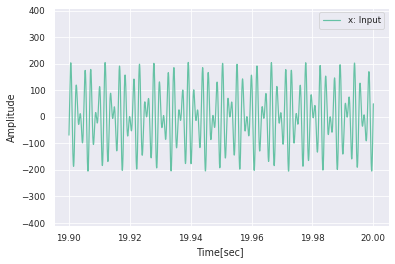

In [57]:
plt.plot(t[-tail:], x_data[-tail:], label="x: Input")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
# plt.grid()
plt.show()

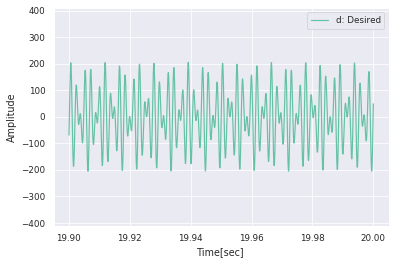

In [58]:
plt.plot(t[-tail:], d_data[-tail:], label="d: Desired")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
# plt.grid()
plt.show()

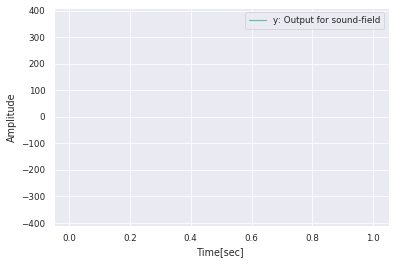

In [59]:
# plt.plot(t[-tail:], y_cache[-tail:], label="y: Output for sound-field")
plt.plot(t[-tail:], y_data[-tail:], label="y: Output for sound-field")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
# plt.grid()
plt.show()

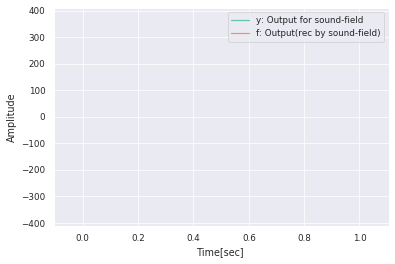

In [60]:
plt.plot(t[-tail:], y_data[-tail:], label="y: Output for sound-field")
plt.plot(t[-tail:], f_data[-tail:], label="f: Output(rec by sound-field)")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.ylim([-2.*A, 2.*A])
plt.legend()
# plt.grid()
plt.show()

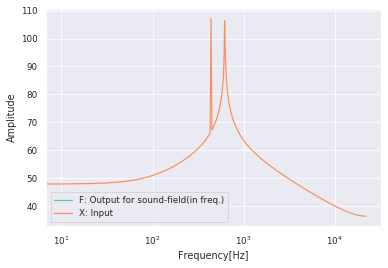

In [61]:
omega = rfftfreq(tail, d=1/fs)
plt.plot(omega, 20*np.log10(rfft(f_data[-tail:])), label="F: Output for sound-field(in freq.)")
plt.plot(omega, 20*np.log10(rfft(x_data[-tail:])), label="X: Input")
plt.xlabel("Frequency[Hz]")
plt.ylabel("Amplitude")
plt.xscale('log')
plt.legend()
# plt.grid()
plt.show()